In [1]:
from full_system_hamiltonian import *
from get_setup import params_for_n_site_Hamiltonian
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import expm
from numba import njit, objmode
from scipy.sparse.linalg import eigsh
import time


In [2]:
n_sites = 3
dupes = 3
big_N = n_sites * dupes

pars, extras = params_for_n_site_Hamiltonian(n_sites, configs=None, specified_vals={"U": [0.1]}, path="/home/Hishem/repos/MastersThesis/configuration.json")


t, U, eps, Delta = pars

print("t, U, eps, Delta =", t, U, eps, Delta)

t_couple = t 
delta_couple = Delta


t: [1. 1.]
U: [0.1 0.1]
eps: [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892]
Delta: [1.001265238594651, 1.0015039227972797]
t, U, eps, Delta = [1. 1.] [0.1 0.1] [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892] [1.001265238594651, 1.0015039227972797]


In [3]:
operators = {}
cre, ann, num = precompute_ops(big_N)
operators['cre'] = cre
operators['ann'] = ann
operators['num'] = num
hop_ops = {}
pair_ops = {}
dens_ops = {}
for i in range(big_N):
    for j in range(i+1, big_N):
        hop_ops[(i,j)] = cre[i] @ ann[j] + ann[i] @ cre[j]
        pair_ops[(i,j)] = cre[i] @ cre[j] + ann[j] @ ann[i]
        dens_ops[(i,j)] = num[i] @ num[j]
operators['hop'] = hop_ops
operators['pair'] = pair_ops
operators['dens'] = dens_ops



In [4]:
def simple_delta_pulse(t, T_peak, width, s, max_val,min_val):
    T_start = T_peak - width / 2
    T_end = T_peak + width / 2

    rise = 1/(1 + np.exp(-s*(t - T_start)))
    fall = 1/(1 + np.exp(s*(t - T_end)))

    return min_val + (max_val - min_val) * rise * fall


In [5]:

def hamiltonian(n, dup, t_vals, U_vals, eps_vals, delta_vals,
               couplings=(), eps_detune=None, operators=None):

    big_N = dup * n
    dim = 2**big_N
    H = np.zeros((dim, dim), dtype=complex)
    if operators is None:
        cre, ann, num = precompute_ops(big_N)
        hop_ops = {}
        pair_ops = {}
        dens_ops = {}
        for i in range(big_N):
            for j in range(i+1, big_N):
                hop_ops[(i,j)] = cre[i] @ ann[j] + ann[i] @ cre[j]
                pair_ops[(i,j)] = cre[i] @ cre[j] + ann[j] @ ann[i]
                dens_ops[(i,j)] = num[i] @ num[j]
    else:
        cre = operators["cre"]
        ann = operators["ann"]
        num = operators["num"]
        hop_ops = operators["hop"]
        pair_ops = operators["pair"]
        dens_ops = operators["dens"]
    # cre, ann, num = precompute_ops(big_N)

    eps_full = np.tile(eps_vals, (dup,1))
    if eps_detune is not None:
        for i in range(len(eps_detune)):
            site, node, val = eps_detune[i]
            eps_full[int(site), int(node)] = val


    # Intra PMM terms
    for d in range(dup):
        off = d * n
        for j in range(n-1):
            i, k = off+j, off+j+1
            H += -t_vals[j]   * hop_ops[(i,k)]
            H +=  delta_vals[j] * pair_ops[(i,k)]
            H +=  U_vals[j]   * dens_ops[(i,k)]

        for j in range(n):
            H += eps_full[d,j] * num[off+j]


    #  Inter PMM couplings
    # print("Couplings:", couplings)
    for cA, cB, t_c, d_c in couplings:
        if cA is None or cB is None:
            continue

        i = cA[0]*n + cA[1]
        j = cB[0]*n + cB[1]
        key = (min(i,j), max(i,j))
        if t_c != 0:
            H += -t_c * hop_ops[key]
        if d_c != 0:
            H +=  d_c * pair_ops[key]
    return H


In [6]:
AB_coupling = [(0,2), (1,0), 0.0, 0.0]
BC_coupling = [(1,0), (2,0), 0.0, 0.0]
CA_coupling = [(2,0), (0,2), 0.0, 0.0]

couplings = [
    AB_coupling,
    BC_coupling,
    CA_coupling
]

# eps_detune = None#{1: 0.0}
# eps_detune = [[0,0,0.0]] #site , node , val
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, operators=operators)


eigvals, eigvecs = np.linalg.eigh(H)
print(eigvals[:10])

[-6.97300714 -6.97291322 -6.97291322 -6.97291322 -6.9728193  -6.9728193
 -6.9728193  -6.97272537 -5.20772486 -5.20772486]


8 8


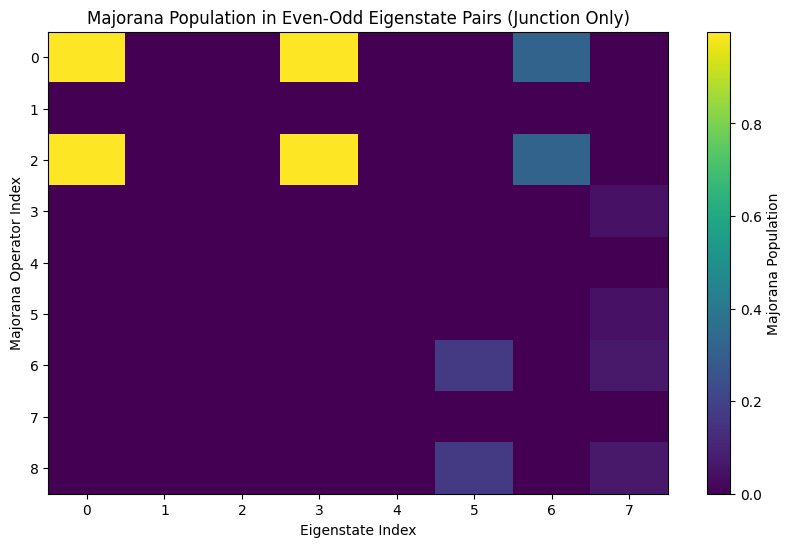

(8, 9)
(0.9982180777569261+0j)
(2.4084400877715983e-05+0j)
(2.4084400877716085e-05-0j)
(0.9982180777569252+0j)
(8.643762676057224e-06-0j)
(0.17144627784007382+0j)
(0.3177055780864195-0j)
(0.06660718597883011+0j)


/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Hishem/miniconda3/envs/myenv/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


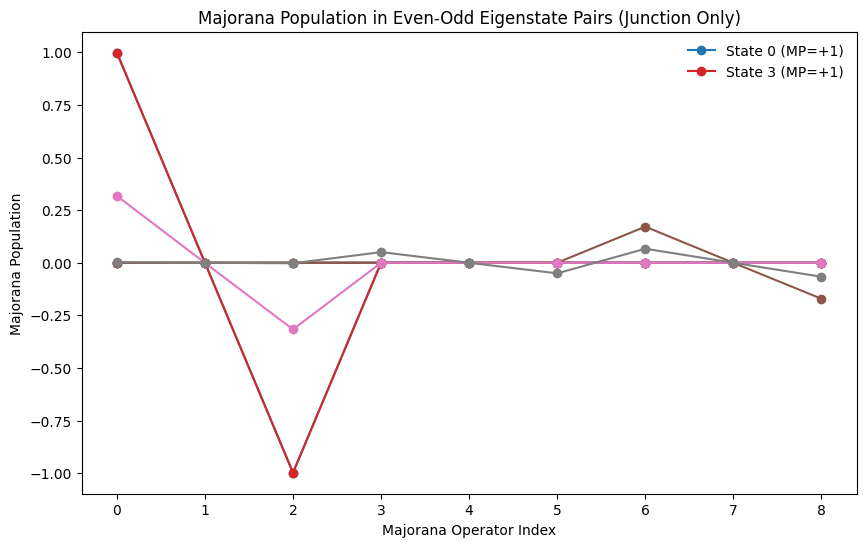

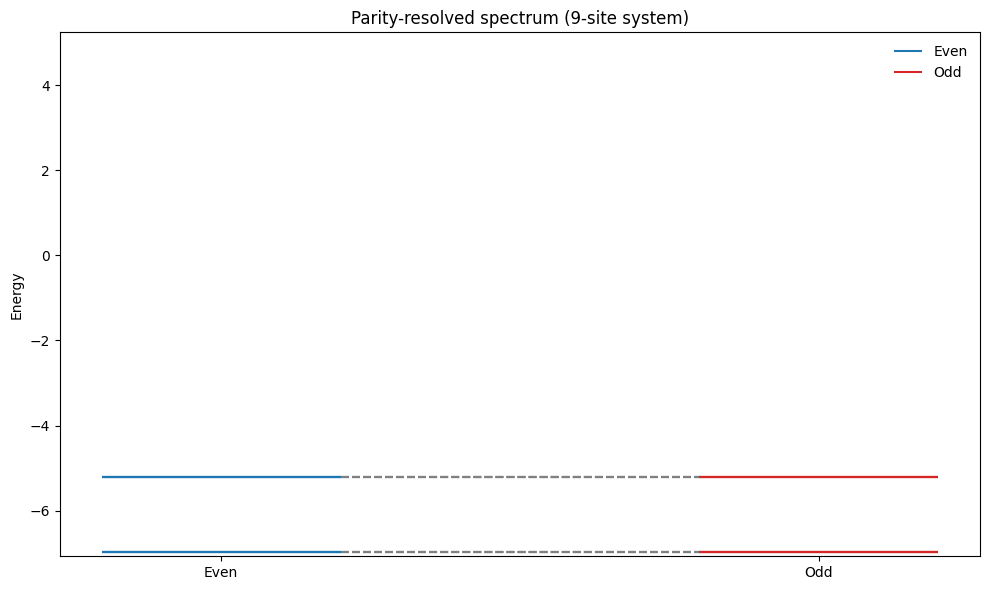

In [7]:
def majorana_operators(n):
    create, annihilate, number = precompute_ops(n)
    majorana_ops = []
    for j in range(n):
        f_dag = create[j]
        f = annihilate[j]
        gamma_1 = f + f_dag
        gamma_2 = -1j * (f - f_dag)
        majorana_ops.append((gamma_1, gamma_2))
    return majorana_ops



def calculate_parities(eigenvecs, eigenvals, number_ops):
    P = total_parity(number_ops)

    #find even and odd parity indexes
    parities = []
    for i in range(eigenvecs.shape[1]):
        vec = eigenvecs[:,i]
        parity = vec.conj().T @ P @ vec
        parities.append(parity.real)
    parities = np.array(parities)
    even_idxs = np.where(parities > 0)[0]
    odd_idxs = np.where(parities < 0)[0]

    even_energies = eigenvals[even_idxs]
    odd_energies = eigenvals[odd_idxs]

    even_vecs = eigenvecs[:, even_idxs]
    odd_vecs = eigenvecs[:, odd_idxs]

    return even_energies, odd_energies, even_vecs, odd_vecs, even_idxs, odd_idxs, parities


cutoff = 8
t, U, eps, Delta = pars
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, operators=operators)
eigvals, eigvecs = np.linalg.eigh(H)
even_energies, odd_energies, even_vecs, odd_vecs, even_idxs, odd_idxs, parities = calculate_parities(eigvecs, eigvals, operators['num'])

even_vecs = even_vecs[:, :cutoff]
odd_vecs = odd_vecs[:, :cutoff]
even_energies = even_energies[:cutoff]
odd_energies = odd_energies[:cutoff]

# print(len(eigvals))
print(len(even_energies), len(odd_energies))
def majorana_population(even_vecs, odd_vecs, majorana_ops):
    M = np.zeros((even_vecs.shape[1], big_N), dtype=np.complex128)

    for j in range(big_N):
        Gamma_1, Gamma_2 = majorana_ops[j]
        for i in range(even_vecs.shape[1]):
            v_e = even_vecs[:, i]
            v_o = odd_vecs[:, i]
            term1 = np.vdot(v_o, Gamma_1 @ v_e)
            term2 = np.vdot(v_o, Gamma_2 @ v_e)
            M[i, j] = term1**2 + term2**2
    return M


majorana_ops = majorana_operators(big_N)



M = majorana_population(even_vecs, odd_vecs, majorana_ops)
plt.figure(figsize=(10,6))
plt.imshow(abs(M.T), aspect='auto', cmap='viridis')
plt.colorbar(label='Majorana Population')
plt.ylabel('Majorana Operator Index')
plt.xlabel('Eigenstate Index')
plt.xticks(ticks=np.arange(M.shape[0]), labels=np.arange(M.shape[0]))
plt.title('Majorana Population in Even-Odd Eigenstate Pairs (Junction Only)')
plt.show()

#give label to those with MP ±1
labels = []
print(M.shape)
for i in range(M.shape[0]):
    print(np.max(M[i,:]))
    if np.isclose(np.max(M[i,:]), 1.0, atol=1e-2):
        labels.append(f'State {i} (MP=+1)')
    elif np.isclose(np.min(M[i,:]), -1.0, atol=1e-2):
        labels.append(f'State {i} (MP=-1)')
    else:
        # continue
        labels.append('')

plt.figure(figsize=(10,6))
for i in range(M.shape[0]):
    plt.plot(range(big_N), M[i], 'o-', label=labels[i] if labels[i] != '' else labels[i])
plt.xlabel('Majorana Operator Index')
plt.ylabel('Majorana Population')
plt.title('Majorana Population in Even-Odd Eigenstate Pairs (Junction Only)')
plt.legend(frameon=False)
plt.show()


plt.figure(figsize=(10,6))
y_even = even_energies
y_odd = odd_energies
degeneracies = []
for ye in y_even:
    for yo in y_odd:
        if np.isclose(ye, yo, atol=1e-2):
            degeneracies.append((ye + yo) / 2)
            break

plt.hlines(y_even, -0.2, 0.2, color='tab:blue', label='Even')
plt.hlines(y_odd,  0.8, 1.2, color='tab:red', label='Odd')
plt.hlines(degeneracies, 0.2, 0.8, color='gray', linestyles='--')
plt.ylim(eigvals.min() - 0.1, eigvals.max() + 0.1)
plt.xticks([0, 1], ["Even", "Odd"])
plt.ylabel("Energy")
plt.title(f"Parity-resolved spectrum ({big_N}-site system)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [50]:
def evolve_system(Total_time, time_steps, params, tJ, dJ, eps_detune_val, cutoff=16):
    """ 
    Information about setup:
    A, B, C = 1, 2, 3
    inner, middle, outer = 0, 1, 2
    Relevant γ's:
    γ_0 = (site 0, node 0)
    γ_1 = (site 0, node 2)
    γ_2 = (site 1, node 0)
    γ_3 = (site 2, node 0)

    Order of connections:
    T = 0:
        γ_0 -- γ_1
            junction_couplings = None
            eps_detune = [[B, outer, eps_detune_val], [C, outer, eps_detune_val]]
    T = 1/3 Total_time:
        γ_0 -- γ_2
            junction_couplings = [AB_coupling]
            eps_detune = [[A, outer, eps_detune_val], [B, outer, eps_detune_val]]
    T = 2/3 Total_time:
        γ_0 -- γ_3
            junction_couplings = [AC_coupling]
            eps_detune = [[A, outer, eps_detune_val], [C, outer, eps_detune_val]]
    T = Total_time:
        γ_0 -- γ_1
            junction_couplings = [BC_coupling]
            eps_detune = [[B, outer, eps_detune_val], [C, outer, eps_detune_val]]
    """
    #Base parameters
    t_val, U_val, eps_val, Delta_val = params
    width = Total_time / 3
    s = 20/width#

    #System setup
    A, B, C = 0, 1, 2
    outer, middle, inner = 2, 1, 0

    time_array = np.linspace(0, Total_time, time_steps)
    eps_detune_min = eps_val[0]
    eps_detune = []
    couplings = []
    for i in range(len(time_array)):
        t = time_array[i]

        #Tune chemical potentials for detuning
        detune_A = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_val, eps_detune_min) + simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_val, eps_detune_min) - eps_detune_min
        
        detune_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_val, eps_detune_min) #+ simple_delta_pulse(t, 0, width, s, eps_detune_val, eps_detune_min)  +  simple_delta_pulse(t, Total_time, width, s, eps_detune_val, eps_detune_min) - 2 * eps_detune_min
        
        detune_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_val, eps_detune_min) #+ simple_delta_pulse(t, 0, width, s, eps_detune_val, eps_detune_min) +  simple_delta_pulse(t, Total_time, width, s, eps_detune_val, eps_detune_min) - 2 * eps_detune_min

        eps_detune.append([[A, outer, detune_A], [B, outer, detune_B], [C, outer, detune_C]])

        # Tune couplings, use detuning pulses
        #Maybe they should follow the detuning PUlse?
        tj_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, tJ, 0.0)
        tj_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, tJ, 0.0)

        dJ_pulse_AB = simple_delta_pulse(t, Total_time/3, width, s, dJ, 0.0)
        dJ_pulse_AC = simple_delta_pulse(t, 2*Total_time/3, width, s, dJ, 0.0)
        # print(f"t={t:.2f}, tj_AB={tj_pulse_AB:.3f}, tj_AC={tj_pulse_AC:.3f}")

        # tj_pulse_BC = simple_delta_pulse(t, 0, width, s, tJ, 0.0) + simple_delta_pulse(t, Total_time, width, s, tJ, 0.0) 
        # dJ_pulse_BC = simple_delta_pulse(t, 0, width, s, dJ, 0.0) + simple_delta_pulse(t, Total_time, width, s, dJ, 0.0) 

        
        coups = [[(A, inner), (B, inner), tj_pulse_AB, dJ_pulse_AB],
                #  [(B, inner), (C, inner), tj_pulse_BC, dJ_pulse_BC],
                 [(C, inner), (A, inner), tj_pulse_AC, dJ_pulse_AC]]
        couplings.append(coups)

    dim = 2**big_N
    eigvals = np.zeros((time_steps, dim), dtype=complex)
    eigvecs = np.zeros((time_steps, 2**big_N, dim), dtype=complex)
    for i in tqdm(range(len(time_array))):

        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=couplings[i],
                          eps_detune=eps_detune[i],
                          operators=operators)
        eigvals_t, eigvecs_t = np.linalg.eigh(H_t)

        eigvals[i] = eigvals_t#[:cutoff]
        eigvecs[i] = eigvecs_t#[:, :cutoff]


    return time_array, couplings, eps_detune, eigvals, eigvecs


Total_time = 300.0
n_time_steps = 1000
tJ = t_couple[0]
dJ = delta_couple[0]
eps_detune_val = tJ*1.1

time_array, couplings, eps_detune, eigvals, eigvecs = evolve_system(Total_time, n_time_steps, pars, tJ, dJ, eps_detune_val)


100%|██████████| 1000/1000 [01:31<00:00, 10.88it/s]


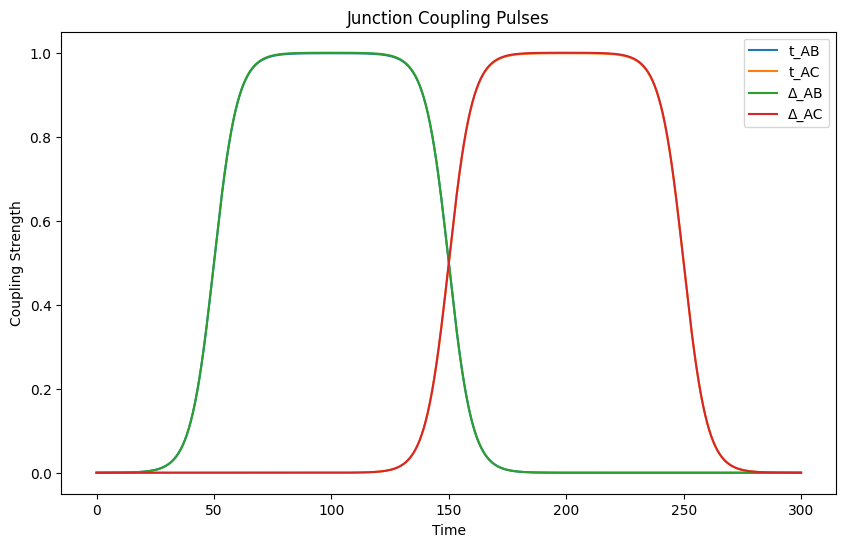

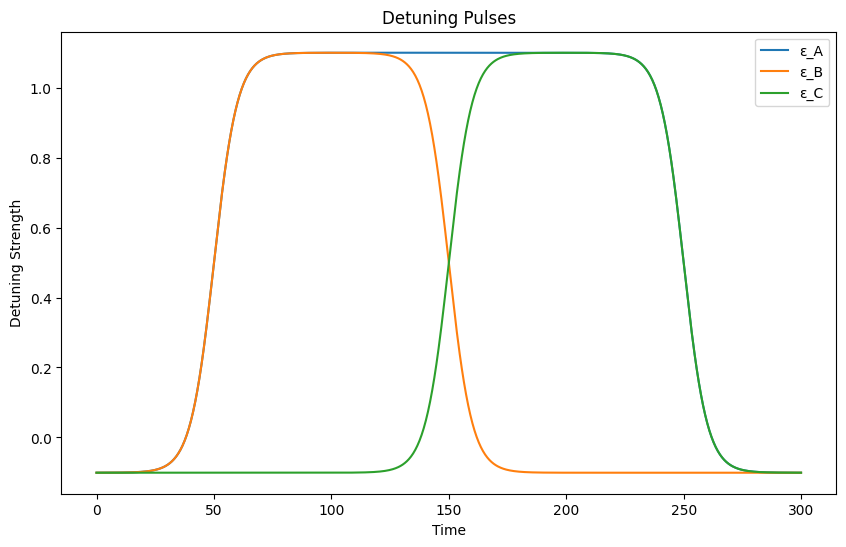

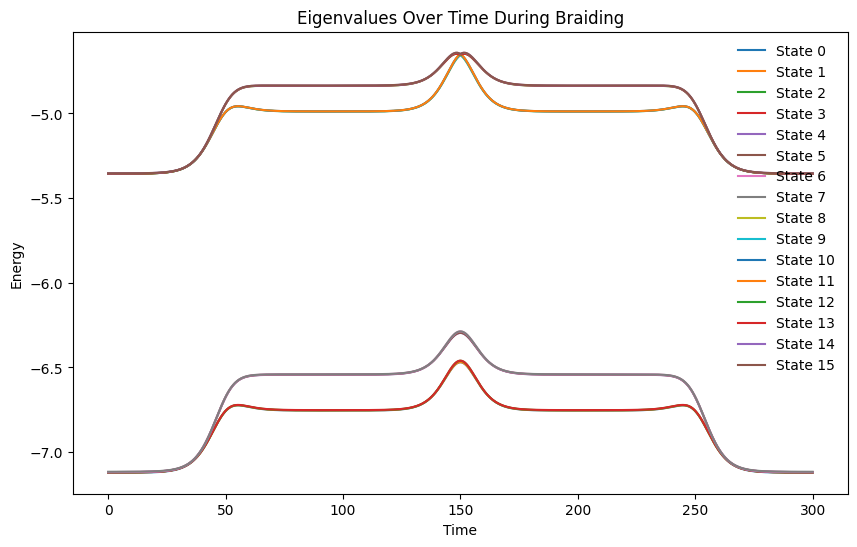

In [52]:

ab_pulse_tJ = [c[0][2] for c in couplings]
ac_pulse_tJ = [c[1][2] for c in couplings]
ab_pulse_dJ = [c[0][3] for c in couplings]
ac_pulse_dJ = [c[1][3] for c in couplings]
# bc_pulse_tJ = [c[1][2] for c in couplings]
# bc_pulse_dJ = [c[1][3] for c in couplings]
#plot pulses
plt.figure(figsize=(10,6))
plt.plot(time_array, ab_pulse_tJ, label='t_AB')
plt.plot(time_array, ac_pulse_tJ, label='t_AC')
plt.plot(time_array, ab_pulse_dJ, label='Δ_AB')
plt.plot(time_array, ac_pulse_dJ, label='Δ_AC')
# plt.plot(time_array, bc_pulse_tJ, label='t_BC')
# plt.plot(time_array, bc_pulse_dJ, label='Δ_BC')

plt.xlabel('Time')
plt.ylabel('Coupling Strength')
plt.title('Junction Coupling Pulses')
plt.legend()
plt.show()

#plot detuning pulses
plt.figure(figsize=(10,6))
plt.plot(time_array, [d[0][2] for d in eps_detune], label='ε_A')
plt.plot(time_array, [d[1][2] for d in eps_detune], label='ε_B')
plt.plot(time_array, [d[2][2] for d in eps_detune], label='ε_C')
plt.xlabel('Time')
plt.ylabel('Detuning Strength')
plt.title('Detuning Pulses')
plt.legend()
plt.show()

eigvals_cut = eigvals[:, :16]
#plot eigenvalues over time
plt.figure(figsize=(10,6))
for i in range(eigvals_cut.shape[1]):
    plt.plot(time_array, eigvals_cut[:,i], label=f'State {i}')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Eigenvalues Over Time During Braiding')
plt.legend(frameon=False)
plt.show()  

In [53]:
from scipy.linalg import expm
def find_ground_state_idxs(eigvals, tol=1e-2):
    E0 = eigvals.min()
    return np.where(np.abs(eigvals - E0) < tol)[0]

def ground_eigenvectors(H, tol=1e-2):
    eigvals, eigvecs = np.linalg.eigh(H)
    ground_state_idxs = find_ground_state_idxs(eigvals, tol=tol)
    return eigvecs[:, ground_state_idxs], ground_state_idxs

def evolve_basis(Total_time, time_steps, params, couplings, detunes):


    t_val, U_val, eps_val, Delta_val = params

    detune = detunes[0]
    coupling = couplings[0]

    time_array = np.linspace(0, Total_time, time_steps)

    
    H0 = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                          couplings=coupling,
                          eps_detune=detune,
                          operators=operators)

    eigvals_0, eigvecs_0 = np.linalg.eigh(H0)
 
    # phi_prev, ground_state_idxs = ground_eigenvectors(H0, tol=1e-2)
    cutoff = 4#len(ground_state_idxs)
    phi_prev = eigvecs_0[:, :cutoff].copy()
    phi0 = eigvecs_0[:, :cutoff].copy()
    Ng = eigvecs_0[:, :cutoff].shape[1]
    print(f"Number of ground states: {Ng}")
    U = np.eye(cutoff, dtype=complex)


    for i in tqdm(range(1, len(time_array))):
        detune = detunes[i]
        coupling = couplings[i]
  
        
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val,
                              couplings=coupling,
                              eps_detune=detune,
                              operators=operators)

        _, phi = np.linalg.eigh(H_t)
        phi = phi[:, :cutoff]
        M = phi_prev.conj().T @ phi

        #Gauge fix
        Uu, _, Vh = np.linalg.svd(M)

        M_gauge = Vh.conj().T @ Uu.conj().T

        U = M_gauge @ U
        phi_prev = phi


    return phi0, phi_prev, U


phi0, phi, U = evolve_basis(Total_time, n_time_steps, pars, couplings, eps_detune)

print("Initial ground states shape:", phi0.shape)
print("phi0:", phi0)
print("Final ground states shape:", phi.shape)
print("phi:", phi)
print("Braiding unitary shape:", U.shape)

#Calculate U eigvals
print("Braiding unitary eigenvalues:")
U_eigvals = np.linalg.eigvals(U)
for val in U_eigvals:
    angle = np.angle(val)
    print(f"Eigenvalue: {val:.4f}, Angle: {angle:.4f} rad, {angle*180/np.pi:.2f}°")

Number of ground states: 4


100%|██████████| 999/999 [01:09<00:00, 14.31it/s]

Initial ground states shape: (512, 4)
phi0: [[-5.29750269e-20+0.j -5.99062359e-18+0.j -6.41576413e-18+0.j
   2.90592822e-05+0.j]
 [ 2.89952834e-05+0.j  4.68869974e-15+0.j -1.23697989e-14+0.j
   4.07864660e-15+0.j]
 [-2.67021482e-05+0.j -4.31493631e-15+0.j  1.13953567e-14+0.j
  -3.75299293e-15+0.j]
 ...
 [-6.67708307e-18+0.j  1.54403047e-10+0.j -1.54426799e-10+0.j
   1.05946232e-01+0.j]
 [ 6.19420178e-17+0.j -1.36236163e-10+0.j  1.36257606e-10+0.j
  -9.34809106e-02+0.j]
 [-8.94160129e-02+0.j -1.81734495e-15+0.j -1.15118094e-14+0.j
   2.49475969e-18+0.j]]
Final ground states shape: (512, 4)
phi: [[ 9.52704962e-18+0.j  4.27053301e-14+0.j -4.37996951e-14+0.j
   2.90592822e-05+0.j]
 [-5.94097938e-14+0.j -3.14952044e-15+0.j  6.90571482e-16+0.j
   2.62146533e-16+0.j]
 [ 5.48650152e-14+0.j  2.82901557e-15+0.j -5.29875326e-16+0.j
  -2.39256314e-16+0.j]
 ...
 [ 2.35486950e-15+0.j  7.49139730e-02+0.j -7.49170887e-02+0.j
  -4.63672884e-12+0.j]
 [-2.01336357e-15+0.j -6.60979712e-02+0.j  6.61007780e

In [38]:
np.linalg.norm(U.conj().T @ U - np.eye(4)) #Close to zero -> numerically clean

np.float64(2.3581165099090757e-13)

In [9]:
def match_even_odd(even_E, odd_E, tol=1e-6):
    pairs = []
    for i, Ee in enumerate(even_E):
        for j, Eo in enumerate(odd_E):
            if abs(Ee - Eo) < tol:
                pairs.append((i, j))
                break
    return pairs


cutoff = 16
Nt = eigvecs.shape[0]

parities_over_time      = []
even_energies_over_time = []
odd_energies_over_time  = []
even_vecs_over_time     = []
odd_vecs_over_time      = []
even_idxs_over_time     = []
odd_idxs_over_time      = []



M = []
for t in tqdm(range(Nt)):
    t = int(t * (Total_time / n_time_steps))
    # print(t)
    eigvals_t = eigvals[t, :cutoff]
    eigvecs_t = eigvecs[t, :, :cutoff]

    (even_E, odd_E,
     even_V, odd_V,
     even_idxs, odd_idxs,
     parities_t) = calculate_parities(
         eigvecs_t, eigvals_t, operators['num']
     )

    parities_over_time.append(parities_t)
    even_energies_over_time.append(even_E)
    odd_energies_over_time.append(odd_E)
    even_vecs_over_time.append(even_V)
    odd_vecs_over_time.append(odd_V)
    even_idxs_over_time.append(even_idxs)
    odd_idxs_over_time.append(odd_idxs)

    pairs_t = match_even_odd(even_energies_over_time[-1],
                         odd_energies_over_time[-1],
                         tol=1e-6)
  

100%|██████████| 1000/1000 [00:49<00:00, 20.12it/s]


In [13]:
U_total = np.eye(8, dtype=complex)

for t in range(Nt-1):   
    V_t  = even_vecs_over_time[t][:, :8]
    V_tp = even_vecs_over_time[t+1][:, :8]

    U_step = V_t.conj().T @ V_tp
    U_total = U_step @ U_total

print(U_total)
print(np.linalg.det(U_total))

[[-9.82720038e-01+0.j -1.09933162e-06+0.j  1.77198145e-01+0.j
  -2.36728859e-03+0.j -4.25678468e-10+0.j -8.07593235e-03+0.j
  -3.54596190e-04+0.j  6.61862607e-09+0.j]
 [-8.66761522e-06+0.j  9.98444197e-01+0.j  4.51202055e-06+0.j
   3.77429407e-03+0.j  9.12095815e-08+0.j -2.14209039e-08+0.j
   3.69903982e-05+0.j -4.50918581e-06+0.j]
 [ 2.34534599e-03+0.j  3.75469880e-03+0.j -3.35478683e-04+0.j
  -9.98712895e-01+0.j -2.80174988e-12+0.j -4.66829345e-06+0.j
   7.82187796e-06+0.j  2.77810439e-06+0.j]
 [-1.77193069e-01+0.j  2.59300049e-06+0.j -9.82861838e-01+0.j
  -8.59679645e-05+0.j  1.27470323e-12+0.j  6.33144205e-04+0.j
  -3.60154067e-05+0.j  2.29611824e-10+0.j]
 [ 1.25226515e-06+0.j -2.15473106e-05+0.j  1.10903652e-05+0.j
  -8.21613813e-06+0.j -7.86476386e-06+0.j -9.37593388e-05+0.j
  -6.88197000e-08+0.j  1.27031241e-10+0.j]
 [ 4.14033310e-10+0.j  9.13783416e-08+0.j -1.65328989e-10+0.j
   4.11043507e-10+0.j -9.98395648e-01+0.j -2.96024866e-11+0.j
   3.72994967e-10+0.j  8.98341104e-07+0.j

In [ ]:
def time_evolution(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=10):
    t_val, U_val, eps_val, Delta_val = params

    tJ, dJ = t_coup_max, Delta_coup_max
    A = 0
    B = 1
    C = 2
    inner = 0 #inner node idx
    outer = 2 #outer node idx
    junction_mode = [
    ((A,inner), (B,inner), tJ, dJ),
    ((B,inner), (C,inner), tJ, dJ),
    ((C,inner), (A,inner), tJ, dJ),
    ]

    width = Total_time / 3
    s = 20/width#Total_time * 6

    time_array = np.linspace(0, Total_time, n_steps)
    dt = time_array[1] - time_array[0]

    #switch from epsilon dicts to np arrays for speed
    # eps_detune_array = np.zeros((n_steps, 3, 3))

    epsilons = []
    for i,t in enumerate(time_array):
        eps_A = simple_delta_pulse(t, 0, width, s, eps_detune_max , 0) + simple_delta_pulse(t, Total_time, width, s, eps_detune_max , 0)
        eps_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_max , 0)
        eps_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_max , 0)

        epsilons.append([
            [A, outer, eps_A],
            [B, outer, eps_B],
            [C, outer, eps_C]
        ])

    
    eigvals = np.zeros((n_steps, lower_bound))
    eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
    # Time Evolution


    for i in tqdm(range(len(time_array))):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=junction_mode, eps_detune=epsilons[i], operators=operators)
        vals, vecs = np.linalg.eigh(H_t)
        eigvals[i,:] = vals[:lower_bound]
        eigvecs[i,:,:] = vecs[:,:lower_bound]




    return eigvals, eigvecs, time_array, epsilons


In [ ]:
T_total = 300
n_steps = 1000
t_coup_max = 1#t_couple[0]/10
Delta_coup_max = 1#delta_couple[0]/10
eps_detune_max = 1.1
lower_bound = 8


eigvals, eigvecs, time_array, coupling_pulses = time_evolution(T_total, n_steps, pars, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=lower_bound)


100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


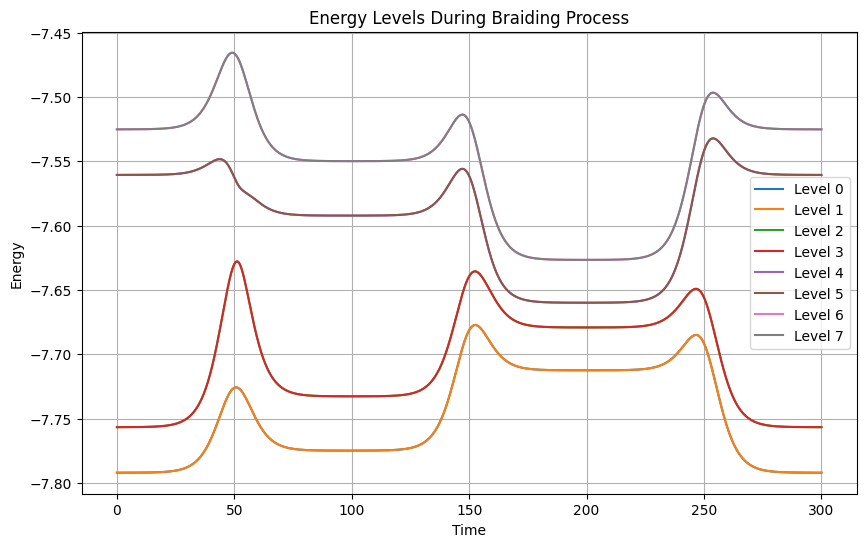

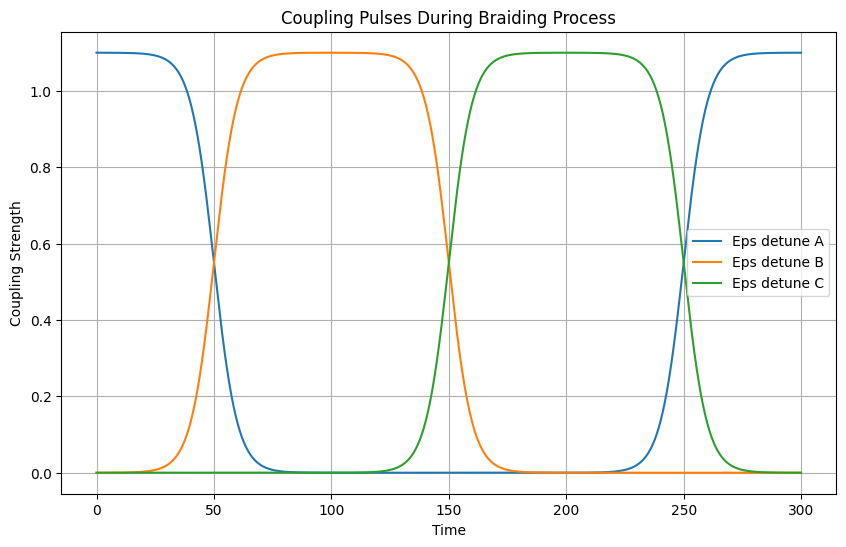

In [ ]:

plt.figure(figsize=(10,6))
for i in range(lower_bound):
    plt.plot(time_array, eigvals[:,i], label=f"Level {i}")
    # plt.show()
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Levels During Braiding Process")
plt.legend()
plt.grid()
plt.show()  

#plot coupling pulses
plt.figure(figsize=(10,6))


epsilonA = [coupling_pulses[i][0][2] for i in range(len(coupling_pulses))]
epsilonB = [coupling_pulses[i][1][2] for i in range(len(coupling_pulses))]
epsilonC = [coupling_pulses[i][2][2] for i in range(len(coupling_pulses))]


plt.plot(time_array, epsilonA, label="Eps detune A")
plt.plot(time_array, epsilonB, label="Eps detune B")
plt.plot(time_array, epsilonC, label="Eps detune C")

plt.xlabel("Time")
plt.ylabel("Coupling Strength")
plt.title("Coupling Pulses During Braiding Process")
plt.legend()
plt.grid()
plt.show()

In [ ]:

def majorana_correlation_matrix(rho, gammas):
    n = len(gammas)
    C = np.zeros((n, n))

    for a in range(n):
        for b in range(n):
            C[a, b] = np.trace(rho @ gammas[a] @ gammas[b]).imag

    return 0.5 * (C - C.T)

num_ops = operators['num']
P = total_parity(num_ops)   # operator, time-independent

Cs = []
t = 0   


for t in [0, int(T_total // 3), int(2 * T_total // 3), int(T_total) ]:

    eigvecs_t = eigvecs[t]     # shape (dim, n_states)
    eigvals_t = eigvals[t]

    # --- parity expectation for instantaneous eigenstates ---
    parities = np.array([
        np.vdot(eigvecs_t[:, k], P @ eigvecs_t[:, k]).real
        for k in range(eigvecs_t.shape[1])
    ])

    # --- select even-parity LOW-ENERGY states ---
    even_states = [k for k in range(len(parities)) if parities[k] > 0.9]

    K = min(lower_bound, len(even_states))
    selected = even_states[:K]

    rho = sum(
        np.outer(eigvecs_t[:, k], eigvecs_t[:, k].conj())
        for k in selected
    ) / K

    gammas = [g for pair in majorana_operators(big_N) for g in pair]
    C = majorana_correlation_matrix(rho, gammas)
    Cs.append(C)

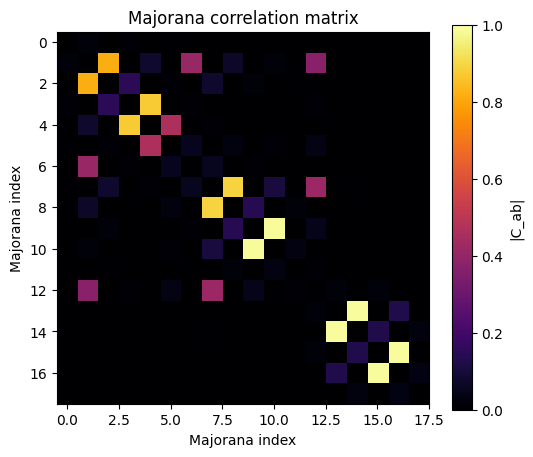

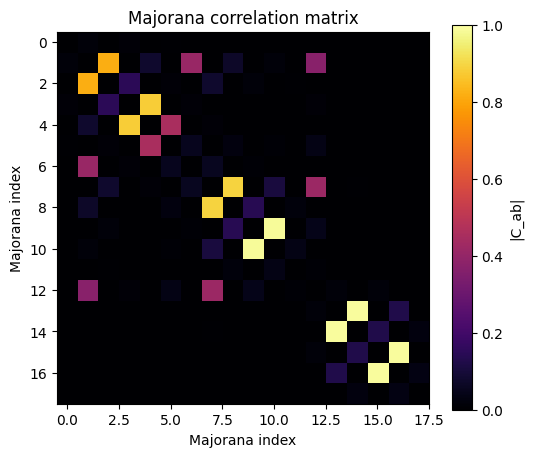

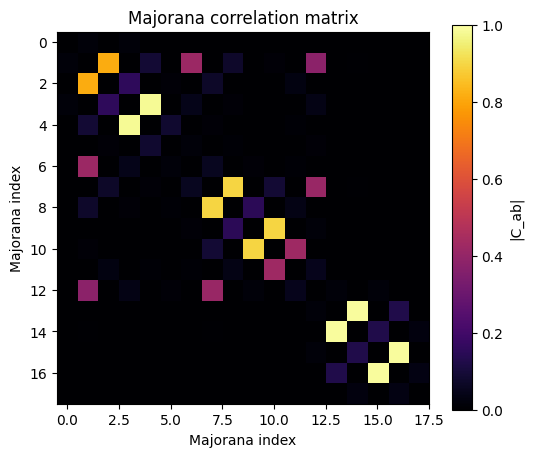

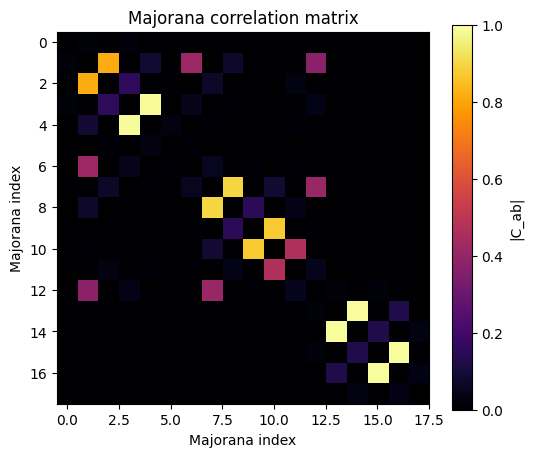

In [ ]:
for idx, C in enumerate(Cs):
    plt.figure(figsize=(6,5))
    plt.imshow(np.abs(C), cmap='inferno', vmax=1)
    plt.colorbar(label='|C_ab|')
    plt.title('Majorana correlation matrix')
    plt.xlabel('Majorana index')
    plt.ylabel('Majorana index')
    plt.show()

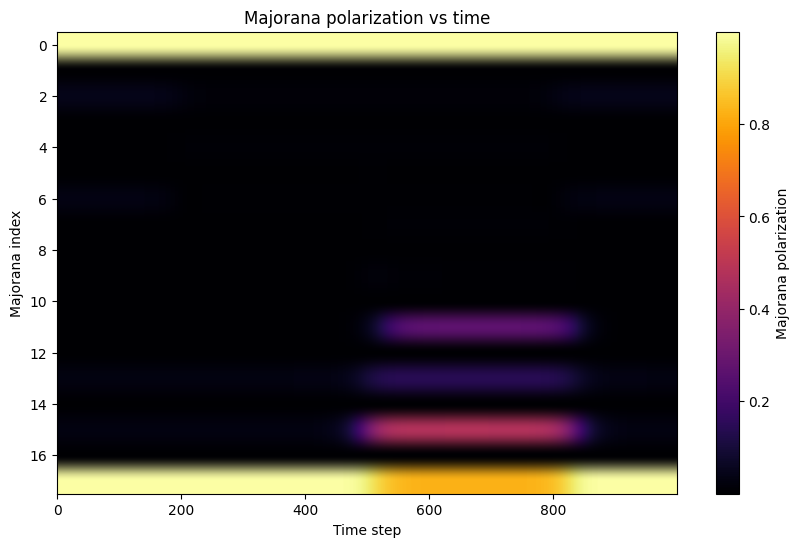

In [ ]:
gammas = [g for pair in majorana_operators(big_N) for g in pair]

def compute_parities(eigvecs_t, P_op):
    """
    eigvecs_t: (dim, n_low)
    """
    return np.array([
        np.vdot(eigvecs_t[:, k], P_op @ eigvecs_t[:, k]).real
        for k in range(eigvecs_t.shape[1])
    ])

def parity_pairs(eigvecs_t, P, tol=0.9):
    par = np.array([
        np.vdot(eigvecs_t[:, k], P @ eigvecs_t[:, k]).real
        for k in range(eigvecs_t.shape[1])
    ])

    even = [k for k in range(len(par)) if par[k] > tol]
    odd  = [k for k in range(len(par)) if par[k] < -tol]

    # pair lowest-energy states
    n = min(len(even), len(odd))
    return even[:n], odd[:n]


def majorana_polarization(eigvecs, gammas, P):
    Nt, dim, nst = eigvecs.shape
    Ng = len(gammas)

    MP = np.zeros((Nt, Ng))

    for t in range(Nt):
        even, odd = parity_pairs(eigvecs[t], P)

        if len(even) == 0:
            continue

        e = even[0]
        o = odd[0]

        psi_e = eigvecs[t][:, e]
        psi_o = eigvecs[t][:, o]

        for i, γ in enumerate(gammas):
            MP[t, i] = abs(np.vdot(psi_o, γ @ psi_e))

    return MP


Parity_operator = total_parity(num_ops)

P = majorana_polarization(eigvecs, gammas, Parity_operator)

plt.figure(figsize=(10,6))
plt.imshow(P.T, aspect='auto', cmap='inferno')
plt.colorbar(label='Majorana polarization')
plt.xlabel('Time step')
plt.ylabel('Majorana index')
plt.title('Majorana polarization vs time')
plt.show()



In [ ]:
from scipy.linalg import svd

def berry_unitary(eigvecs):
    """
    eigvecs: shape (Nt, dim, n_low)
    returns: U_Berry (n_low x n_low)
    """
    Nt, dim, n_low = eigvecs.shape

    U = np.eye(n_low, dtype=complex)

    for i in range(Nt - 1):
        Psi_t  = eigvecs[i]      # (dim, n_low)
        Psi_tp = eigvecs[i + 1]  # (dim, n_low)

        # overlap matrix
        M = Psi_t.conj().T @ Psi_tp  # (n_low, n_low)

        # polar decomposition → nearest unitary
        U_m, _, Vh = svd(M)
        M_unitary = U_m @ Vh

        U = M_unitary @ U

    return U

print("Calculating Berry unitary...")
U_Berry = berry_unitary(eigvecs)
phase = np.linalg.det(U_Berry)**(1/lower_bound)
U_Berry /= phase
print("Berry unitary U_Berry:")
# print(U_Berry)
print(U_Berry.shape)
print(np.sort(np.angle(np.linalg.eigvals(U_Berry))))

Calculating Berry unitary...
Berry unitary U_Berry:
(8, 8)
[-0.42634458 -0.39269908 -0.35905358  2.51502623  2.74416415  2.74889357
  2.75362299  2.98276092]


In [ ]:
from scipy.linalg import expm
majorana_pairs = majorana_operators(big_N)
Psi0 = eigvecs[0]  # (dim, n_low)

weights = []
for i, gamma in enumerate(gammas):
    w = np.linalg.norm(Psi0.conj().T @ gamma @ Psi0)
    weights.append(w)

for i in range(len(weights)):
    print(f"Majorana {i}: weight = {weights[i]:.4f}")
braided = np.argsort(weights)[-2:]
i, j = braided
print("Braided Majoranas:", i, j)


U_full = expm((np.pi / 4) * gammas[i] @ gammas[j])
U_target = Psi0.conj().T @ U_full @ Psi0
phase = np.linalg.det(U_target)**(1/lower_bound)
U_target /= phase
print("Target unitary U_target:")
print("Berry eigenphases:",
      np.sort(np.angle(np.linalg.eigvals(U_Berry))))
print("Target eigenphases:",
      np.sort(np.angle(np.linalg.eigvals(U_target))))


Majorana 0: weight = 2.8276
Majorana 1: weight = 0.2744
Majorana 2: weight = 1.5517
Majorana 3: weight = 1.2952
Majorana 4: weight = 0.3106
Majorana 5: weight = 2.4987
Majorana 6: weight = 2.5672
Majorana 7: weight = 0.0911
Majorana 8: weight = 1.1775
Majorana 9: weight = 0.0786
Majorana 10: weight = 0.2902
Majorana 11: weight = 2.8264
Majorana 12: weight = 2.3310
Majorana 13: weight = 0.0881
Majorana 14: weight = 0.0521
Majorana 15: weight = 0.0795
Majorana 16: weight = 0.0431
Majorana 17: weight = 2.8259
Braided Majoranas: 11 0
Target unitary U_target:
Berry eigenphases: [-0.42634458 -0.39269908 -0.35905358  2.51502623  2.74416415  2.74889357
  2.75362299  2.98276092]
Target eigenphases: [-0.78493938 -0.78493938 -0.78487526 -0.78487526  0.78483829  0.78483829
  0.78497635  0.78497635]


## Savings

In [ ]:
# H = big_H(n_sites, dupes, t, U, eps, Delta, couplings=couplings, eps_detune=eps_detune, operators=operators)

# ordered_couplings = {
#     "AB": {
#         "idx0": (0,2),
#         "idx1": (1,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
#     "eps_detune": None,
#     "BC": {
#         "idx0": (1,0),
#         "idx1": (2,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
# }


# def time_evolve(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=10):

    
#     t_val, U_val, eps_val, Delta_val = params

#     couplings = []
#     eps_detune = {}
#     OC = ordered_couplings
#     for i in range(len(OC)): 
#         key = list(OC.keys())[i]
        
#         current = OC[key]
#         print(current)
#         if key == "eps_detune":
#             if current is not None:
#                 eps_detune = current
#             else: 
#                 eps_detune = {1: eps_detune_max}
#         else:
#             if current['t_coup'] is None:
#                 current['t_coup'] = t_coup_max
#             if current['Delta_coup'] is None:
#                 current['Delta_coup'] = Delta_coup_max
#             couplings.append([current['idx0'], current['idx1'], current['t_coup'], current['Delta_coup']])

#     print("Couplings for time evolution:", couplings)
#     print("Eps detune for time evolution:", eps_detune)


#     #Create Coupling pulse arrays:
#     time_array = np.linspace(0, Total_time, n_steps)
#     dt = time_array[1] - time_array[0]
#     ##Order of pulses AB peak at T=0 and T=Total_time, Eps Detune at T=Total_time/3, BC at T=2*Total_time/3
#     AB_t_peaks = [Total_time/3]#[0, Total_time]
#     BC_t_peaks = [2*Total_time/3]
#     eps_t_peaks = [0, Total_time]#[Total_time/3]

#     width = Total_time / 3
#     s = 20/width#Total_time * 6

#     All_Couplings = []
#     epsilons = []

#     # Precompute the pulses
#     for t in time_array:

#         eps_detune_val = simple_delta_pulse(t, eps_t_peaks[0], width, s, eps_detune_max , 0) + simple_delta_pulse(t, eps_t_peaks[1], width, s, eps_detune_max , 0)
#         epsilons.append(eps_detune_val)
        
#         current_couplings = []
#         for i,coup in enumerate(couplings):
#             # print(i, coup)
#             if i == 0:
#                 curr_t = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[2] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[3] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)
#             else:
#                 curr_t = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)

#         All_Couplings.append(current_couplings)
    

#     coupling_pulses = {
#         "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
#         "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
#         "eps_detune": epsilons
#     }

#     eigvals = np.zeros((n_steps, lower_bound))
#     eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
#     # Time Evolution
#     tJ = t_coup_max
#     dJ = Delta_coup_max
#     A = 0
#     B = 1
#     C = 2
#     gamma0_coupling = couplings = [
#     ((A,2), (B,0), tJ, dJ),
#     ((B,0), (C,0), tJ, dJ),
#     ((C,0), (A,2), tJ, dJ),
#     ]
#     #For each time step in ALL couplings, append gamma0coupling as well
#     for i in range(len(All_Couplings)):
#         for coup in gamma0_coupling:
#             All_Couplings[i].append(coup)
    
#     print(All_Couplings[0])

#     for i in tqdm(range(len(time_array))):
#         # H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune={1: epsilons[i]}, operators=operators)
#         H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune=0, operators=operators)
#         vals, vecs = np.linalg.eigh(H_t)
#         eigvals[i,:] = vals[:lower_bound]
#         eigvecs[i,:,:] = vecs[:,:lower_bound]

    
#     return eigvals, eigvecs, time_array, coupling_pulses
# T_total = 300
# n_steps = 1000
# t_coup_max = t_couple[0]/10
# Delta_coup_max = delta_couple[0]/10
# eps_detune_max = 1/10
# lower_bound = 8


# eigvals, eigvecs, time_array, coupling_pulses = time_evolve(T_total, n_steps, pars, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=lower_bound)


def time_evolution(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=10):
    print("Hei")
    t_val, U_val, eps_val, Delta_val = params

    tJ, dJ = t_coup_max, Delta_coup_max
    A = 0
    B = 1
    C = 2
    junction_mode = [
    ((A,2), (B,0), tJ, dJ),
    ((B,0), (C,0), tJ, dJ),
    ((C,0), (A,2), tJ, dJ),
    ]

    width = Total_time / 3
    s = 20/width#Total_time * 6

    time_array = np.linspace(0, Total_time, n_steps)
    dt = time_array[1] - time_array[0]

    eps_A_dict = {"site_idxs": [A], "node_idxs": [0], "vals": [0.0]}
    eps_B_dict = {"site_idxs": [B], "node_idxs": [2], "vals": [0.0]}
    eps_C_dict = {"site_idxs": [C], "node_idxs": [2], "vals": [0.0]}


    All_Couplings = []
    epsilons = []
    for t in time_array:
        eps_A = simple_delta_pulse(t, 0, width, s, eps_detune_max , 0) + simple_delta_pulse(t, Total_time, width, s, eps_detune_max , 0)
        eps_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_max , 0)
        eps_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_max , 0)

        eps_A_dict["vals"] = [eps_A]
        eps_B_dict["vals"] = [eps_B]
        eps_C_dict["vals"] = [eps_C]
        epsilons.append([eps_A_dict, eps_B_dict, eps_C_dict])




        # AB_coup_t = simple_delta_pulse(t, 0, width, s, t_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, t_coup_max , 0)
        # AB_delta_t = simple_delta_pulse(t, 0, width, s, Delta_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, Delta_coup_max , 0)

        # BC_coup_t = simple_delta_pulse(t, Total_time/3, width, s, t_coup_max , 0)
        # BC_delta_t = simple_delta_pulse(t, Total_time/3, width, s, Delta_coup_max , 0)   

        # current_couplings = [
        #     ((A,2), (B,0), AB_coup_t, AB_delta_t),
        #     ((B,0), (C,0), BC_coup_t, BC_delta_t),
        # ]
        # junction mode
        # if t < Total_time / 3:
        #     current_couplings.append(junction_mode[0])
        # elif t < 2 * Total_time / 3:
        #     current_couplings.append(junction_mode[1])
        # else:
        #     current_couplings.append(junction_mode[2])

        # All_Couplings.append(current_couplings)
    
    pulse_info = {
        # "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
        # "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
        # "eps_detune": epsilons
        "epsA": [epsilons[i][0]["vals"] for i in range(len(epsilons))],
        "epsB": [epsilons[i][1]["vals"] for i in range(len(epsilons))],
        "epsC": [epsilons[i][2]["vals"] for i in range(len(epsilons))]
    }
    
    eigvals = np.zeros((n_steps, lower_bound))
    eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
    # Time Evolution
    for i in tqdm(range(len(time_array))):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=junction_mode, eps_detune=epsilons[i], operators=operators)
        vals, vecs = np.linalg.eigh(H_t)
        eigvals[i,:] = vals[:lower_bound]
        eigvecs[i,:,:] = vecs[:,:lower_bound]

    return eigvals, eigvecs, time_array, pulse_info




